<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
</font>
<p></p>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Depp Learning - Dr. Fatemizadeh
</font>
<br/>
Fall 2022

</div>

<hr/>
<div align=center>
    <font color=red>
	Practical Assignment 2
	</font>
	<p></p>
	<font>
	World Cup 2020
	</font>
</div>
</div>

# Personal Data

In [1]:
student_number = 98102527
Name = 'Ali'
Last_Name = 'Nourian'

# Import Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from time import localtime

# Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Import Data and Visualization

In [4]:
df = pd.read_csv('international_matches.csv')
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


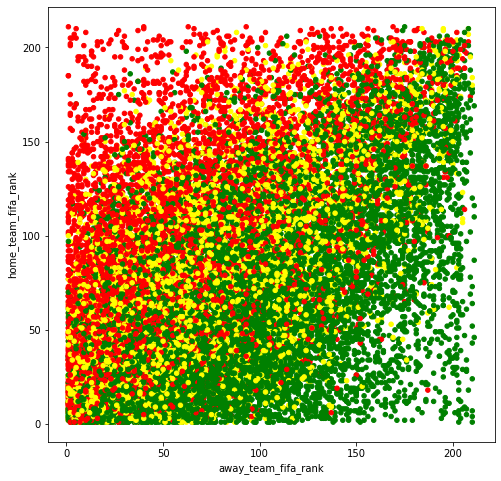

In [5]:
def toColor(x):
    if x == 'Win':
        return 'green'
    elif x == 'Draw':
        return 'yellow'
    else:
        return 'red'

df_win_lose = df[['away_team_fifa_rank', 'home_team_fifa_rank', 'home_team_result']].copy()
df_win_lose.loc[:,'home_team_result'] = df['home_team_result'].apply(toColor)

df_win_lose.plot.scatter(x='away_team_fifa_rank', y='home_team_fifa_rank', c='home_team_result', figsize=(8, 8));

# Prepare Data for Train

In [6]:
def toLabel(x):
    if x == 'Win':
        return 2
    elif x == 'Draw':
        return 1
    else:
        return 0

def normalize(x):
    mu = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    y = (x - mu) / std
    return y

In [17]:
# ================================ get features ================================
cleaned_df = df[['home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_result']].copy()

# ============================== remove bad data ===============================
cleaned_df = cleaned_df[(cleaned_df['home_team_total_fifa_points'] > 0) & (cleaned_df['away_team_total_fifa_points'] > 0)]

# =============================== normalize data ===============================
help_df = cleaned_df[['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points']]
dfmu = help_df.mean()
dfmax = help_df.max()
cleaned_df[
    ['home_team_fifa_rank',
     'away_team_fifa_rank', 
     'home_team_total_fifa_points', 
     'away_team_total_fifa_points'
    ]
] = (help_df - dfmu) / dfmax

# ================================ re-index df =================================
cleaned_df = cleaned_df.reset_index(drop=True)

# ============================= split train & test =============================
n_win = sum(cleaned_df['home_team_result'] == 'Win')
n_draw = sum(cleaned_df['home_team_result'] == 'Draw')
n_lose = sum(cleaned_df['home_team_result'] == 'Lose')

train_size = (int(0.75 * n_win), int(0.75 * n_draw), int(0.75 * n_lose))
test_size = n_win - train_size[0], n_draw - train_size[1], n_lose - train_size[2]

print(train_size, test_size)

win_df = cleaned_df[cleaned_df['home_team_result'] == 'Win'].reset_index(drop=True)
draw_df = cleaned_df[cleaned_df['home_team_result'] == 'Draw'].reset_index(drop=True)
lose_df = cleaned_df[cleaned_df['home_team_result'] == 'Lose'].reset_index(drop=True)

train_win_df = win_df.iloc[0:train_size[0]]
train_draw_df = draw_df.iloc[0:train_size[1]]
train_lose_df = lose_df.iloc[0:train_size[2]]
train_df = pd.concat([train_win_df, train_draw_df, train_lose_df], ignore_index=True)

test_win_df = win_df.iloc[train_size[0]:]
test_draw_df = draw_df.iloc[train_size[1]:]
test_lose_df = lose_df.iloc[train_size[2]:]
test_df = pd.concat([test_win_df, test_draw_df, test_lose_df], ignore_index=True)

# =============== change labels 'Win', 'Draw', 'Lose' to 2, 1, 0 ===============
train_df.loc[:, 'home_team_result'] = train_df['home_team_result'].apply(toLabel)
test_df.loc[:, 'home_team_result'] = test_df['home_team_result'].apply(toLabel)

train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)

# ========================== cast df to torch tensor ===========================
x_train = torch.tensor(train_df.iloc[:,2:6].values, dtype=torch.float32)
y_train = torch.tensor(train_df.iloc[:,6].values).type(torch.LongTensor)

x_test = torch.tensor(test_df.iloc[:,2:6].values, dtype=torch.float32)
y_test = torch.tensor(test_df.iloc[:,6].values).type(torch.LongTensor)

# =========================== convert sets to loader ===========================
train_set = list(map(lambda x, y: (x, y), x_train, y_train))
test_set = list(map(lambda x, y: (x, y), x_test, y_test))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

print(sum(y_train == 2), sum(y_train == 1), sum(y_train == 0))
print(sum(y_test == 2), sum(y_test == 1), sum(y_test == 0))

(3492, 1629, 2073) (1165, 543, 692)
tensor(3492) tensor(1629) tensor(2073)
tensor(1165) tensor(543) tensor(692)


## Correlation

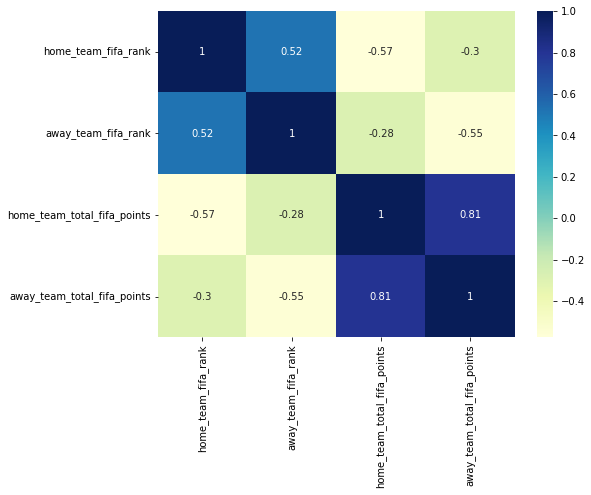

In [18]:
data = cleaned_df[['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points']]

plt.subplots(figsize=(8, 6))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True);

# Training Functions

In [89]:
def train_epoch(net, criterion, optimizer, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  train_loss = 0
  train_accuracy = 0
  i = 0

  net.train()
  for i, (x, y) in enumerate(dataloader):
    # x = x.to(device)
    # y = y.type(torch.FloatTensor)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()
    
    train_loss = epoch_loss / (i + 1)
    train_accuracy = epoch_true / epoch_all

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  return train_loss, train_accuracy


def evaluate_epoch(net, criterion, dataloader):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  eval_loss = 0
  eval_accuracy = 0
  i = 0

  net.eval()
  for i, (x, y) in enumerate(dataloader):
    # x = x
    # y = y.type(torch.FloatTensor)
    p = net(x)

    loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    eval_loss = epoch_loss / (i + 1)
    eval_accuracy = epoch_true / epoch_all

  return eval_loss, eval_accuracy


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, train_loader, test_loader=None):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for e in range(n_epochs):
        train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader)
        if test_loader is not None:
            test_loss, test_accuracy = evaluate_epoch(net, criterion, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(float(train_accuracy))
        if test_loader is not None:
            test_losses.append(test_loss)
            test_accuracies.append(float(test_accuracy))

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
        if test_loader is not None:
            print(f'Test Loss: {test_loss:.4f}\t\tTest Accuracy: {test_accuracy:.2f}')
        else:
            print()
    
    return train_losses, train_accuracies, test_losses, test_accuracies

# Define Model

In [10]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.input_dim = 4
        self.hidden_dims=[10, 20, 8]
        self.output_dim=3
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[1], self.hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[2], self.output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.fc(x)

## Test Model

In [90]:
net = MyNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss, train_acc, _, _= train_model(net, 10, train_loader)

[Epoch 1]	 [23:34:38]	Train Loss: 1.0234	Train Accuracy: 0.51	
[Epoch 2]	 [23:34:39]	Train Loss: 0.9702	Train Accuracy: 0.57	
[Epoch 3]	 [23:34:39]	Train Loss: 0.9700	Train Accuracy: 0.56	
[Epoch 4]	 [23:34:39]	Train Loss: 0.9707	Train Accuracy: 0.56	
[Epoch 5]	 [23:34:40]	Train Loss: 0.9719	Train Accuracy: 0.56	
[Epoch 6]	 [23:34:40]	Train Loss: 0.9704	Train Accuracy: 0.56	
[Epoch 7]	 [23:34:41]	Train Loss: 0.9714	Train Accuracy: 0.56	
[Epoch 8]	 [23:34:41]	Train Loss: 0.9700	Train Accuracy: 0.56	
[Epoch 9]	 [23:34:41]	Train Loss: 0.9719	Train Accuracy: 0.56	
[Epoch 10]	 [23:34:42]	Train Loss: 0.9701	Train Accuracy: 0.56	


In [91]:
y_hat = net.forward(x_test)

pred = torch.argmax(y_hat, axis=1)
acc = sum(y_test == pred) / y_test.shape[0] * 100
print(f'accuracy: {acc}')

accuracy: 60.041664123535156


# Define New Model

In [86]:
class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()

        self.input_dim = 4
        self.hidden_dims=[8, 20, 6]
        self.output_dim=3
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[1], self.hidden_dims[2]),
            nn.ReLU(),
            # nn.Linear(self.hidden_dims[2], self.hidden_dims[3]),
            # nn.ReLU(),
            nn.Linear(self.hidden_dims[2], self.output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.fc(x)

## Test New Model

In [92]:
net2 = MyNet2()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=2e-3, weight_decay=1e-4)
# optimizer = torch.optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

train_loss, train_acc, test_loss, test_acc = train_model(net2, 10, train_loader)

[Epoch 1]	 [23:34:51]	Train Loss: 1.0550	Train Accuracy: 0.46	
[Epoch 2]	 [23:34:51]	Train Loss: 0.9809	Train Accuracy: 0.56	
[Epoch 3]	 [23:34:52]	Train Loss: 0.9685	Train Accuracy: 0.57	
[Epoch 4]	 [23:34:52]	Train Loss: 0.9684	Train Accuracy: 0.57	
[Epoch 5]	 [23:34:53]	Train Loss: 0.9675	Train Accuracy: 0.56	
[Epoch 6]	 [23:34:53]	Train Loss: 0.9675	Train Accuracy: 0.57	
[Epoch 7]	 [23:34:53]	Train Loss: 0.9674	Train Accuracy: 0.57	
[Epoch 8]	 [23:34:54]	Train Loss: 0.9666	Train Accuracy: 0.57	
[Epoch 9]	 [23:34:55]	Train Loss: 0.9668	Train Accuracy: 0.57	
[Epoch 10]	 [23:34:55]	Train Loss: 0.9668	Train Accuracy: 0.57	


In [93]:
y_hat = net2.forward(x_test)

pred = torch.argmax(y_hat, axis=1)
acc = sum(y_test == pred) / y_test.shape[0] * 100
print(f'accuracy: {acc}')

accuracy: 60.41666793823242


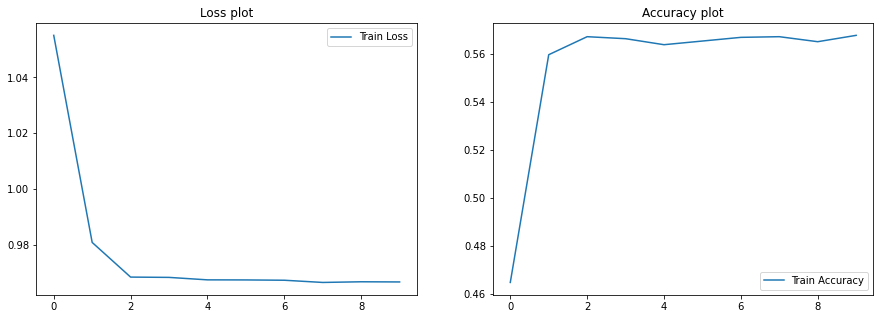

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_loss)
axis.set_title('Loss plot')
axis.legend(['Train Loss'])

axis = axes[1]
axis.plot(train_acc)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy'])

# IRAN Games Prediction

In [122]:
iran_df = cleaned_df[(cleaned_df['home_team'] == 'IR Iran') | (cleaned_df['away_team'] == 'IR Iran')].reset_index(drop=True)
iran_df.head()

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_result
0,IR Iran,Indonesia,-0.140212,0.212041,-0.114017,-0.267129,Win
1,Qatar,IR Iran,0.025665,-0.157628,-0.203666,-0.104929,Draw
2,IR Iran,Palestine,-0.154430,0.358960,-0.105699,-0.312877,Win
3,IR Iran,Bahrain,-0.154430,0.074600,-0.105699,-0.208441,Win
4,Bahrain,IR Iran,0.087276,-0.209760,-0.222150,-0.073968,Draw


In [120]:
columns= [
    'home_team',
    'away_team',
    'home_team_fifa_rank',
    'away_team_fifa_rank',
    'home_team_total_fifa_points',
    'away_team_total_fifa_points',
    'home_team_result'
]
index= range(3)
data = [
    ['IR Iran', 'England', 20, 5, 1564, 1728, 0],
    ['IR Iran', 'Wales', 20, 19, 1564, 1569, 2],
    ['IR Iran', 'America', 20, 16, 1564, 1627, 0]
]
Iran_df = pd.DataFrame(data, index, columns)

Iran_df.iloc[:,2:6] = (Iran_df.iloc[:,2:6] - dfmu) / dfmax

x_test = torch.tensor(Iran_df.iloc[:,2:6].values, dtype=torch.float32)
y_test = torch.tensor(Iran_df.iloc[:,6].values).type(torch.LongTensor)

In [121]:
y_hat = net.forward(x_test)

for i in range(3):
    print(f'{data[i][0]} vs {data[i][1]}:\twin ({y_hat[i][2]}),\tdraw ({y_hat[i][1]}),\tlose ({y_hat[i][0]})')

IR Iran vs England:	win (0.4262573719024658),	draw (0.11819984018802643),	lose (0.45554283261299133)
IR Iran vs Wales:	win (0.7020405530929565),	draw (0.09215853363275528),	lose (0.2058008909225464)
IR Iran vs America:	win (0.6309351921081543),	draw (0.10232949256896973),	lose (0.26673534512519836)
